In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
tar_path = '/content/drive/MyDrive/segmentation-project/neurite-oasis.v1.0.tar'
extract_path = '/content/segmentation_data'
os.makedirs(extract_path, exist_ok=True)

# Extract if needed
!tar -xf "{tar_path}" -C "{extract_path}"

In [ ]:
# Overwrite seg4_paths.txt with updated correct paths
with open("seg4_paths.txt", "r") as f:
    lines = f.readlines()

with open("seg4_paths.txt", "w") as f:
    for line in lines:
        updated = line.replace("neurite-oasis.v1.0", "segmentation_data")
        f.write(updated)

print("✅ Done! seg4_paths.txt now uses 'segmentation_data'.")

✅ Done! seg4_paths.txt now uses 'segmentation_data'.


In [ ]:
!python convert_one_hot.py --txt_path seg4_paths.txt

Processing segmentation maps: 100% 414/414 [04:02<00:00,  1.70it/s]


In [ ]:
import os

# Check if one-hot file exists for first subject
print("Sample file:", os.listdir("segmentation_data/OASIS_OAS1_0395_MR1"))

Sample file: ['slice_orig.nii.gz', 'orig.nii.gz', 'slice_seg4.nii.gz', 'slice_norm.nii.gz', 'slice_seg24.nii.gz', 'norm.nii.gz', 'aligned_norm.nii.gz', 'aligned_seg35.nii.gz', 'seg4_onehot.npy', 'aligned_orig.nii.gz', 'aligned_seg4.nii.gz', 'seg4.nii.gz', 'seg35.nii.gz']


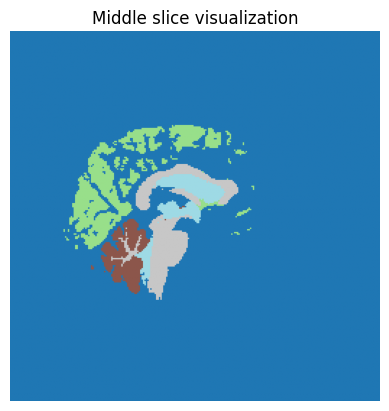

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy')
middle_slice = data.argmax(axis=0)[data.shape[1] // 2]
plt.imshow(middle_slice, cmap='tab20')
plt.title("Middle slice visualization")
plt.axis('off')
plt.show()

In [ ]:
!python train.py --train_txt /content/drive/MyDrive/segmentation-project/train_split.txt --template_path segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy --batch_size 1 --epochs 50

Streaming output truncated to the last 5000 lines.
Cross-entropy: 0.906790
Training for epoch: 44/50:  71% 278/394 [08:17<03:27,  1.79s/it]Affine Dice Loss: 0.4280 -> Final Dice: 0.0145
Cross-entropy: 0.906827
Training for epoch: 44/50:  71% 279/394 [08:18<03:25,  1.78s/it]Affine Dice Loss: 0.4573 -> Final Dice: 0.0177
Cross-entropy: 0.907362
Training for epoch: 44/50:  71% 280/394 [08:20<03:24,  1.79s/it]Affine Dice Loss: 0.3955 -> Final Dice: 0.0170
Cross-entropy: 0.907292
Training for epoch: 44/50:  71% 281/394 [08:22<03:22,  1.79s/it]Affine Dice Loss: 0.4639 -> Final Dice: 0.0154
Cross-entropy: 0.906819
Training for epoch: 44/50:  72% 282/394 [08:24<03:20,  1.79s/it]Affine Dice Loss: 0.4650 -> Final Dice: 0.0179
Cross-entropy: 0.907371
Training for epoch: 44/50:  72% 283/394 [08:26<03:18,  1.79s/it]Affine Dice Loss: 0.4664 -> Final Dice: 0.0158
Cross-entropy: 0.906630
Training for epoch: 44/50:  72% 284/394 [08:27<03:16,  1.78s/it]Affine Dice Loss: 0.4006 -> Final Dice: 0.0144
Cros

In [ ]:
from get_data import SegDataset
from model import RegistrationModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_txt_path = '/content/drive/MyDrive/segmentation-project/train_split.txt'
template_path = 'segmentation_data/OASIS_OAS1_0016_MR1/seg4_onehot.npy'
model_path = 'checkpoints/affine_unet_model.pth'

# Re-create dataset and dataloader
train_dataset = SegDataset(train_txt_path, template_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

# Re-create and load your trained model
volume_size = train_dataset[0][0].shape[1:]
model = RegistrationModel(volume_size, num_channels=5).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

RegistrationModel(
  (affine_predictor): AffineParameterPredictor(
    (encoder): Sequential(
      (0): Conv3d(10, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): AdaptiveAvgPool3d(output_size=1)
    )
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=12, bias=True)
    )
  )
  (affine_stn): AffineSpatialTransformer()
  (unet): UNet(
    (enc1): Sequential(
      (0): Conv3d(10, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
 

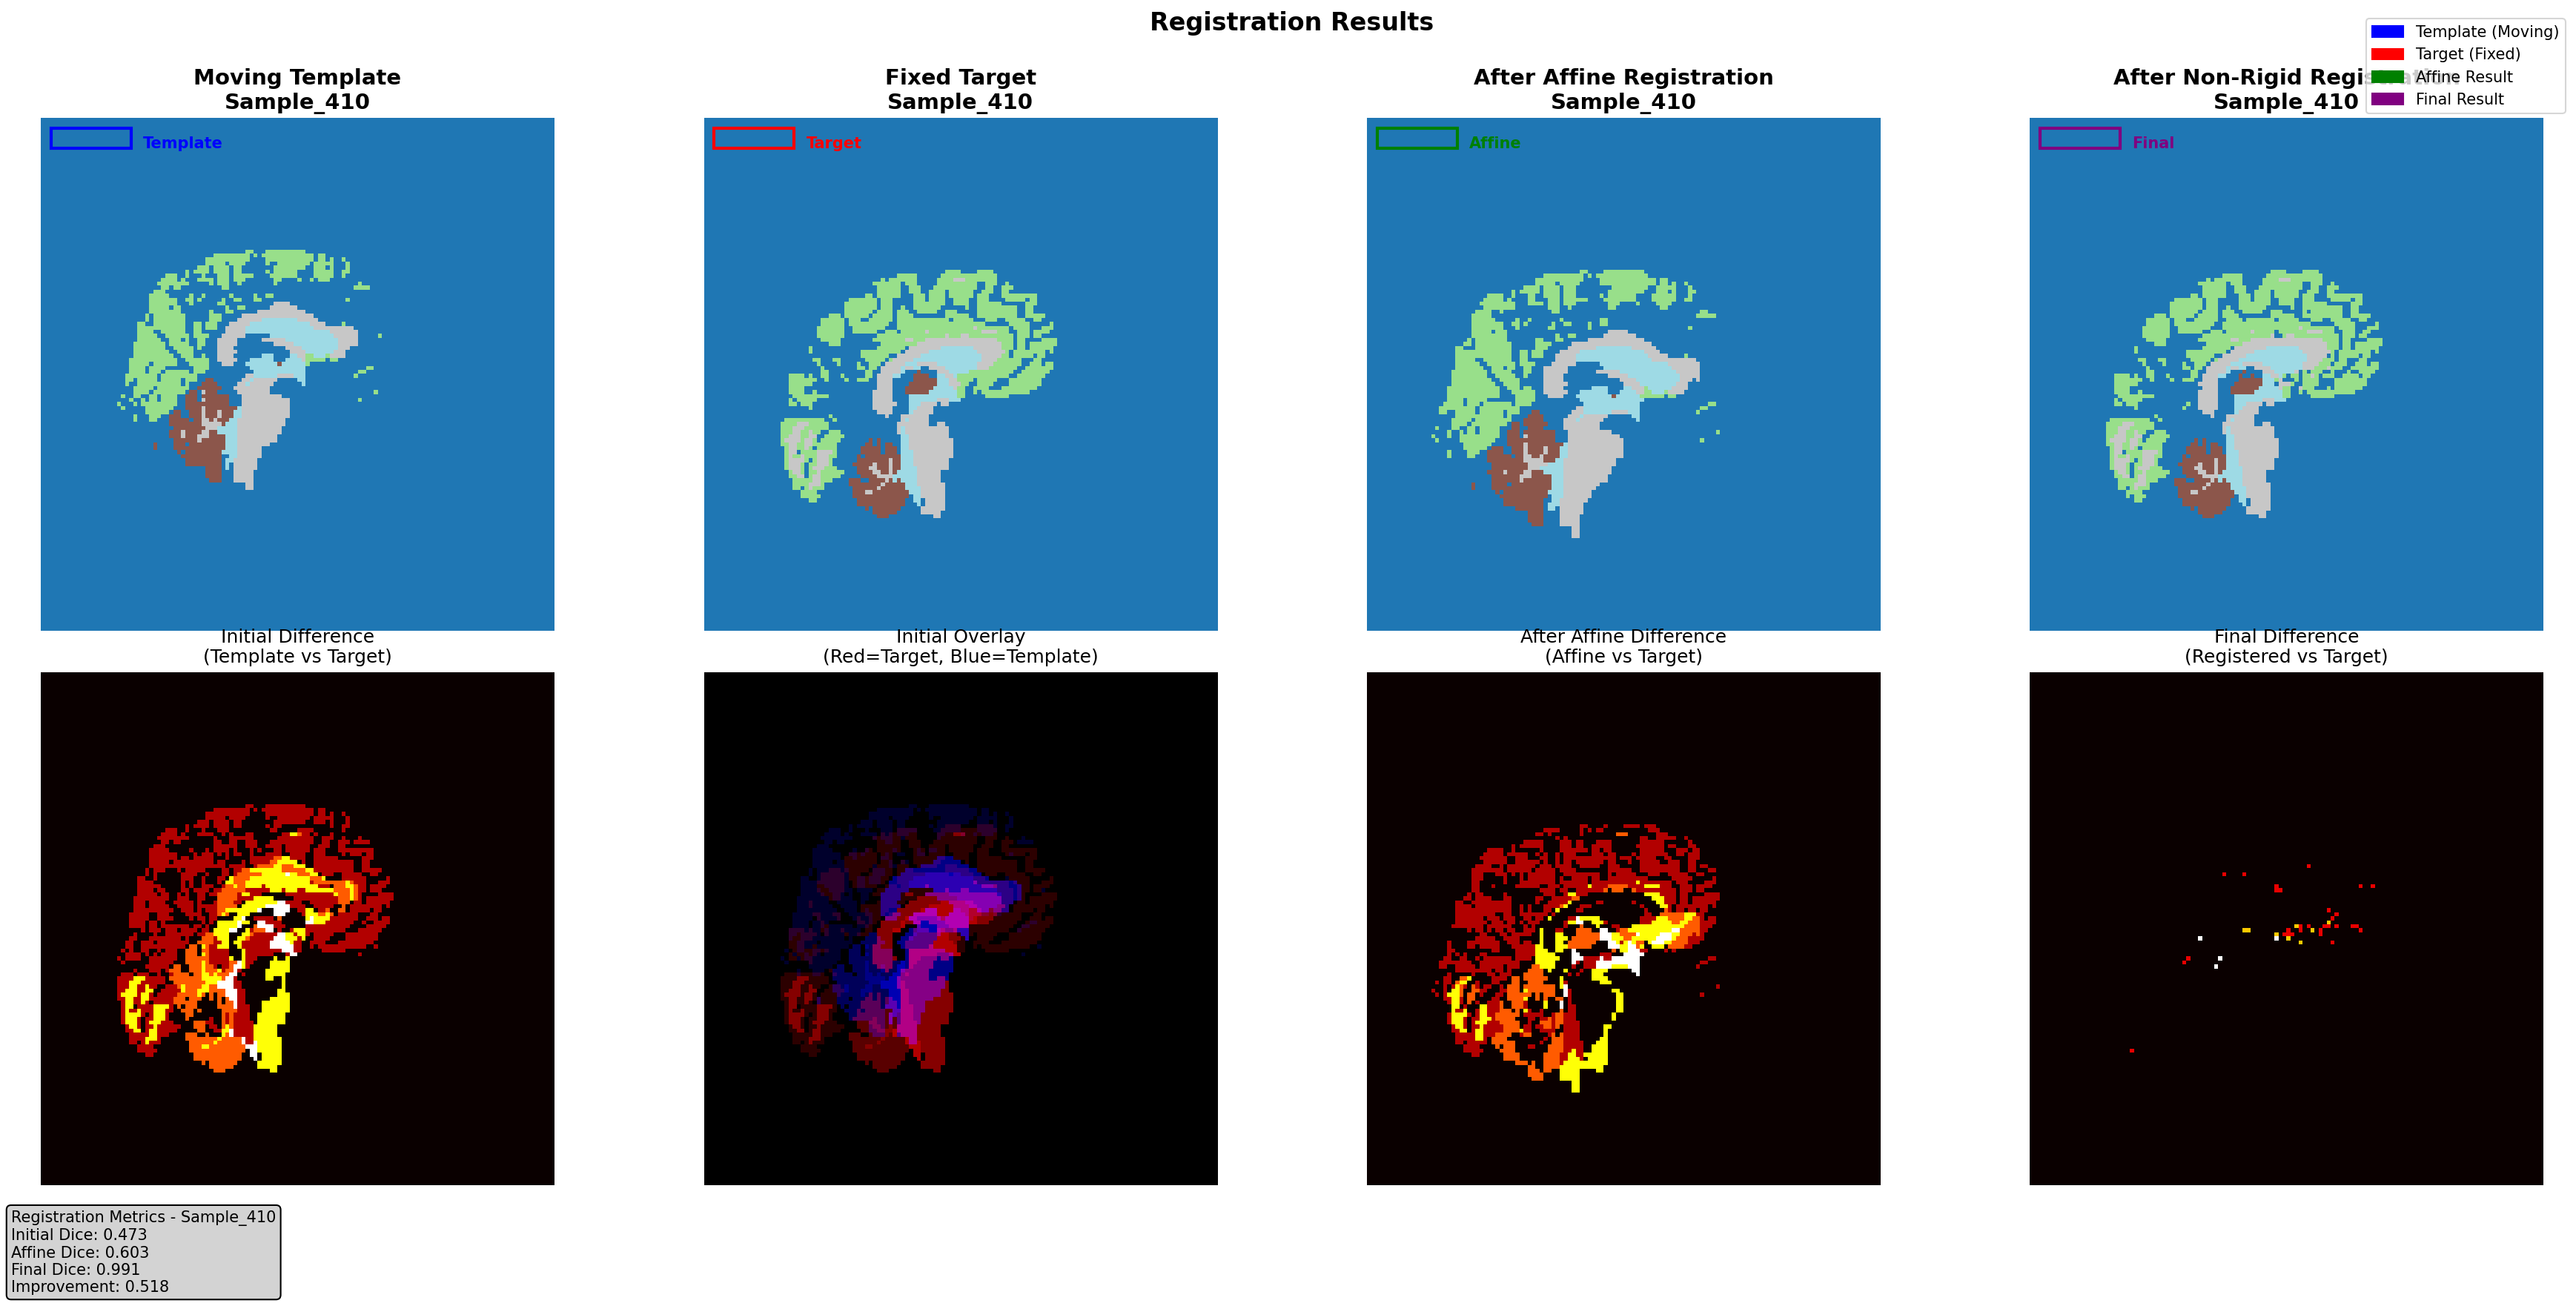

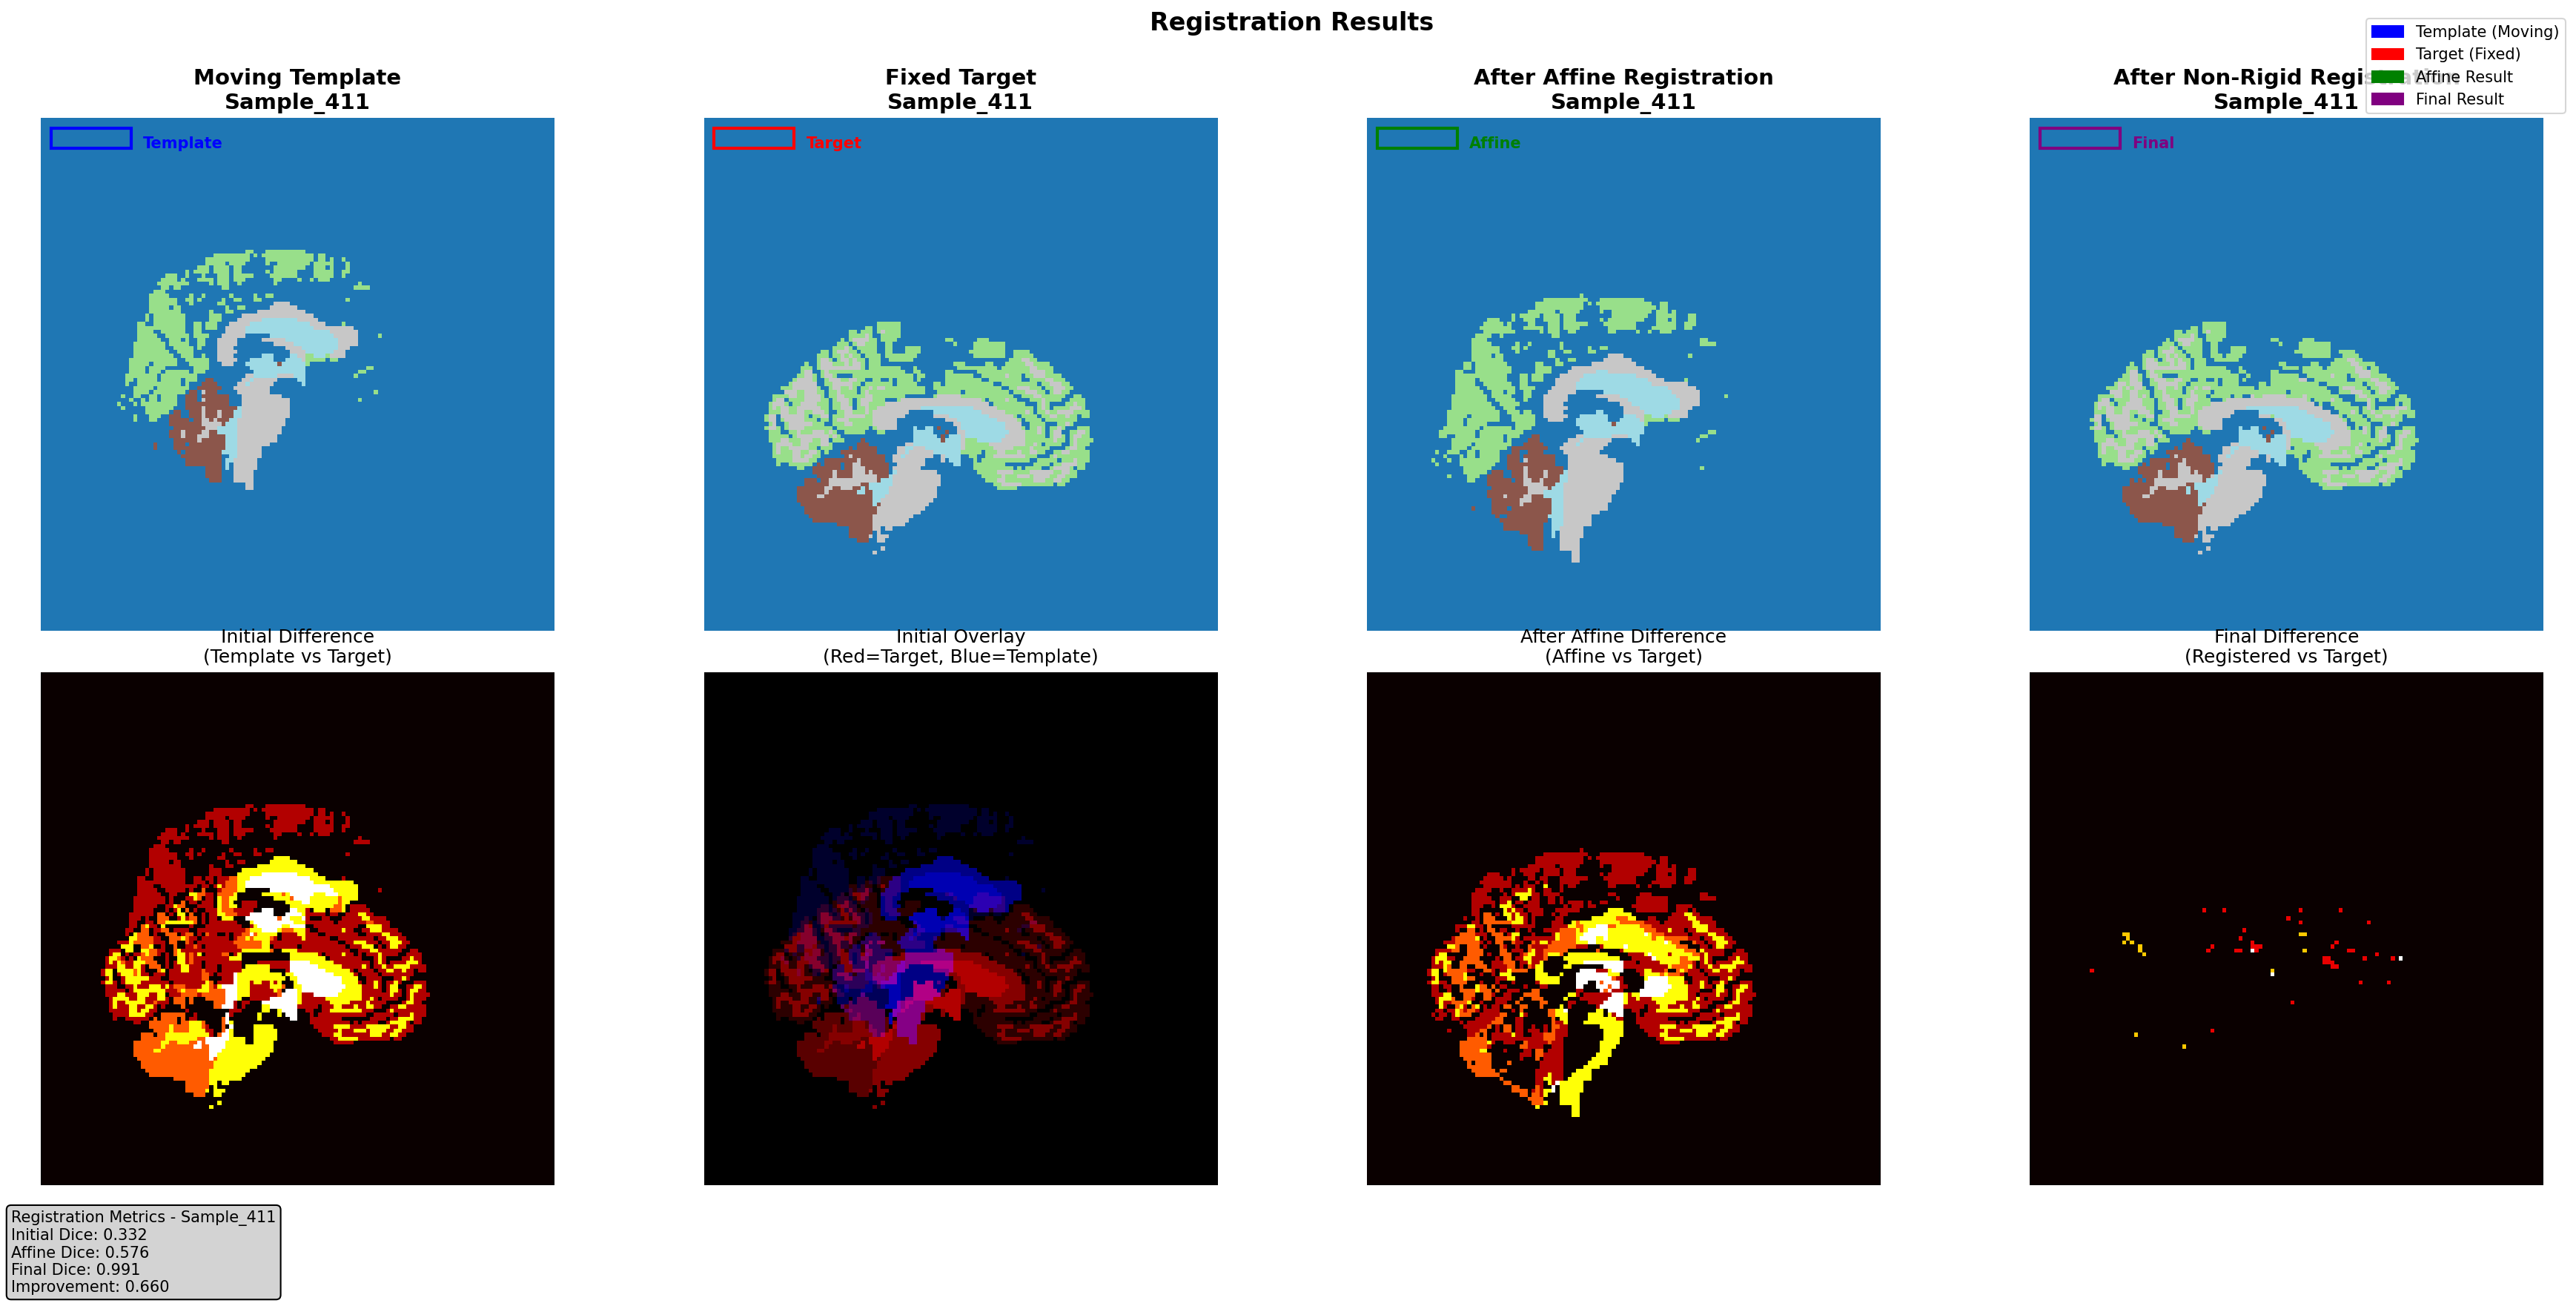

In [ ]:
sample_batch = next(iter(train_loader))
moving, fixed = sample_batch
moving = moving.to(device)
fixed = fixed.to(device)

with torch.no_grad():
    warped_template, affine_matrix, deformation_field, affine_warped = model(moving, fixed)

from visualize import visualize_registration_colab
visualize_registration_colab(moving, fixed, affine_warped, warped_template)

In [ ]:
# saving the model

!cp checkpoints/affine_unet_model.pth /content/drive/MyDrive/segmentation-project/